**Project**: Funny Image Classification

In [37]:
import torch
import numpy as np

from transformers import (
    AutoImageProcessor, AutoModelForImageClassification,
    AutoModelForObjectDetection, ImageClassificationPipeline,
    TrainingArguments, Trainer, pipeline
)

import albumentations as A

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    RandomRotation,
    RandomAutocontrast,
    ToTensor,
)

from transformers.image_utils import load_image
import evaluate
from datasets import load_dataset

from matplotlib import pyplot as plt
from PIL import Image

from requests import get

from transformers import pipeline
import pandas as pd

from datasets import Dataset, DatasetDict, load_metric
from sklearn.model_selection import train_test_split

In [23]:
f = open("Image_class_10_gr/synsets.txt", "r")
label_mapping = {}
for i, j in enumerate(f):
    label_mapping[i] = j.rstrip()

def load_image_(image_path):
    return Image.open('All photos _ 10 groups/' + image_path)

file_path = "Image_class_10_gr/default.txt"
with open(file_path, "r") as file:
    lines = file.readlines()

image_paths = []
labels = []

for line in lines:
    parts = line.split()
    image_paths.append(parts[0])
    labels.append(int(parts[1]))

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

train_images = [load_image_(path) for path in train_image_paths]
test_images = [load_image_(path) for path in test_image_paths]

train_dataset = Dataset.from_dict({"image": train_images, "label": train_labels})
test_dataset = Dataset.from_dict({"image": test_images, "label": test_labels})

dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 160
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 40
    })
})


In [325]:
metric = load_metric("accuracy")

C:\Users\Ilya\anaconda3\envs\gpu_1\lib\site-packages\datasets\load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [326]:
example = dataset["test"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=235x363>,
 'label': 8}

In [327]:
dataset["train"].features

{'image': Image(decode=True, id=None), 'label': Value(dtype='int64', id=None)}

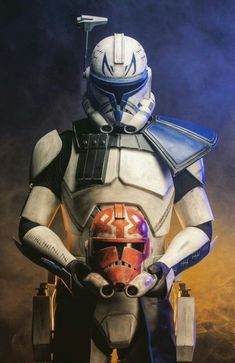

In [328]:
example['image']

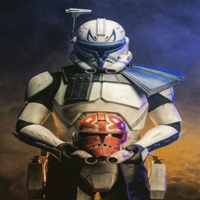

In [329]:
example['image'].resize((200, 200))

In [330]:
example['label']

8

In [331]:
dataset["train"].features["label"]

Value(dtype='int64', id=None)

In [332]:
id2label = label_mapping
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

({0: 'jedi',
  1: 'sith',
  2: 'mortal_combat',
  3: 'wizard',
  4: 'transformers',
  5: 'orcs',
  6: 'droids',
  7: 'navi',
  8: 'clones',
  9: 'wookiee'},
 {'jedi': 0,
  'sith': 1,
  'mortal_combat': 2,
  'wizard': 3,
  'transformers': 4,
  'orcs': 5,
  'droids': 6,
  'navi': 7,
  'clones': 8,
  'wookiee': 9})

In [334]:
# model_checkpoint = "microsoft/resnet-50"
model_checkpoint = "train_image_kabyte_10_groups_4/checkpoint-2000"

In [335]:
batch_size = 16

In [336]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

ConvNextImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "crop_pct",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [337]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [338]:
train_ds = dataset['train']
val_ds = dataset['test']

In [339]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [340]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 172
})

In [341]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

In [343]:
args = TrainingArguments(
    "train_image_kabyte_10_groups_4",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs=100,
    learning_rate=5e-5,
)

In [344]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [345]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [346]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

C:\Users\Ilya\anaconda3\envs\gpu_1\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [347]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.540102,0.837209
2,No log,0.556156,0.790698
3,No log,0.512390,0.837209
4,No log,0.490857,0.837209
5,No log,0.512915,0.813953
6,No log,0.527277,0.883721
7,No log,0.494970,0.860465
8,No log,0.532572,0.860465
9,No log,0.485730,0.860465
10,No log,0.497935,0.860465


***** train metrics *****
  epoch                    =       25.0
  total_flos               = 85100433GF
  train_loss               =     0.5344
  train_runtime            = 0:03:47.21
  train_samples_per_second =     18.925
  train_steps_per_second   =      2.421


In [348]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       25.0
  eval_accuracy           =     0.8605
  eval_loss               =     0.5239
  eval_runtime            = 0:00:05.68
  eval_samples_per_second =      7.558
  eval_steps_per_second   =      1.055


# Тест

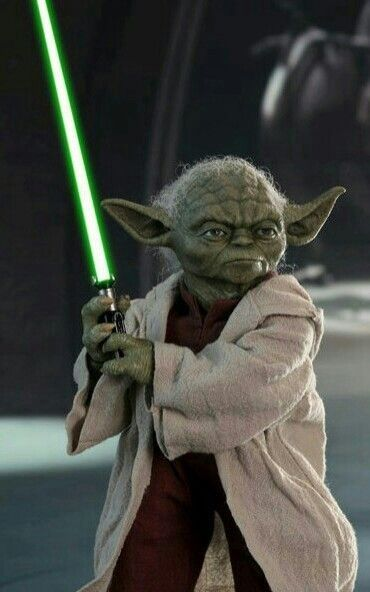

In [24]:
import random
j = random.randint(0,39)
image = dataset['test'][j]['image']
image

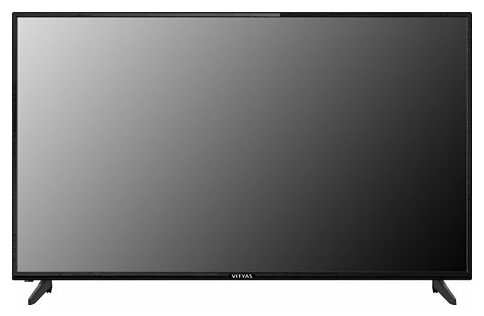

In [38]:
image = Image.open('Тестовые фото/'+'17156062100694d7b115c7fd9f770fc4.jpg')
image

In [39]:
rus_names = {'jedi':'Джедай', 'sith':'Ситх', 'clones':'Клон (штурмовик)',
            'transformers':'Трансформер', 'droids':'Дроид', 'wookiee':'Вуки',
            'wizard':'Волшебник', 'mortal_combat':'Персонаж из Mortal Combat',
            'orcs':'Орк', 'navi':'Нави'}

In [40]:
classifier = pipeline("image-classification", model='train_image_kabyte_10_groups_4/checkpoint-2000')
print(f"На картинке изображен {rus_names[classifier(image)[0]['label']]}")
classifier(image)

На картинке изображен Трансформер


[{'label': 'transformers', 'score': 0.1206163689494133},
 {'label': 'droids', 'score': 0.10816098004579544},
 {'label': 'orcs', 'score': 0.1033782958984375},
 {'label': 'clones', 'score': 0.10303498059511185},
 {'label': 'wookiee', 'score': 0.1008453518152237}]

In [41]:
label_list = []
score_list = []
for i in range(len(classifier(image))):
    label_list.append(rus_names[classifier(image)[i]['label']])
    score_list.append(str(f"{round(classifier(image)[i]['score']*100, 2)} %"))

table = df.to_string(columns = ['Кто на рисунке', 'Вероятность'], index = False, header = False, line_width = 70, justify = 'right')
print(table)

     Трансформер 12.06 %
           Дроид 10.82 %
             Орк 10.34 %
Клон (штурмовик)  10.3 %
            Вуки 10.08 %
